Contains VAR model experiments for synthetic networks.
We examine the following random networks grid, small-world,
scale-free, and Erd˝os-Rényi 

Grid graph

In [1]:
#####################################
#Generating the Scale-free networks
#####################################
import numpy as np
from line_profiler import profile
np.random.seed(42)
@profile
def grid_graph(nrow, ncol, c):
    p = nrow * ncol  # Total number of nodes
    val = c
    adj_matrix = np.eye(p, dtype=('float64'))

    for i in range(nrow):
        for j in range(ncol):
            node = i * ncol + j
            # Up
            if i > 0:
                neighbor = (i - 1) * ncol + j
                adj_matrix[node, neighbor] = val
                adj_matrix[neighbor, node] = val
            # Down
            if i < nrow - 1:
                neighbor = (i + 1) * ncol + j
                adj_matrix[node, neighbor] = val
                adj_matrix[neighbor, node] = val
            # Left
            if j > 0:
                neighbor = i * ncol + (j - 1)
                adj_matrix[node, neighbor] = val
                adj_matrix[neighbor, node] = val
            # Right
            if j < ncol - 1:
                neighbor = i * ncol + (j + 1)
                adj_matrix[node, neighbor] = val
                adj_matrix[neighbor, node] = val

    return adj_matrix

Scale-free graphs

In [2]:
#####################################
#Generating the Scale-free networks
#####################################
import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import cmath
import math
def BAgraph_undir(N, mo, m):
    np.random.seed(42)
    A = np.zeros((N, N))
    for i in range(mo):
        for j in range(i + 1, mo):
            A[i, j] = 1
            A[j, i] = 1

    for i in range(mo, N):
        degrees = np.sum(A, axis=0)
        total_degree = np.sum(degrees)
        probabilities = degrees / total_degree
        connected_nodes = np.random.choice(range(i), size=m, replace=False, p=probabilities[:i])

        for node in connected_nodes:
            A[i, node] = 1
            A[node, i] = 1

    return A

Small world graphs

In [3]:
#####################################
#Generating the Small-world networks
#####################################

import numpy as np
import cvxpy as cp
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Define your small-world graph generator
def smallw(N, K, beta):
    np.random.seed(42)
    s = np.repeat(np.arange(N), K)
    t = (s.reshape((N, K)) + np.arange(1, K + 1)) % N
    t = t.flatten()

    for source in range(N):
        for i in range(K):
            if np.random.rand() < beta:
                possible_targets = np.setdiff1d(np.arange(N), np.concatenate(([source], t[s == source])))
                if len(possible_targets) > 0:
                    new_target = np.random.choice(possible_targets)
                    t[np.where((s == source) & (t == t[s == source][i]))[0]] = new_target

    A = np.zeros((N, N))
    for i in range(len(s)):
        A[s[i], t[i]] = 1
        A[t[i], s[i]] = 1

    return A

Erdos Renyi graphs

In [4]:
#####################################
#Generating the ER networks
#####################################

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools

def getNodeCoordinates(nv):
    theta = np.linspace(0, 2 * np.pi, nv, endpoint=False)
    x = 10 * np.cos(theta)
    y = 10 * np.sin(theta)
    return x, y

def permPairs(N):
    pairs = list(itertools.combinations(range(N), 2))
    return np.array(pairs)

def plotGraphBasic(adj_matrix, x, y, marker_size=50, add_text=True):
    G = nx.Graph(adj_matrix)
    pos = {i: (x[i], y[i]) for i in range(len(x))}

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=add_text, node_size=marker_size, node_color='blue', edge_color='gray')
    plt.show()

def erdosRenyi(nv, p, Kreg):
    np.random.seed(42)
    # Build regular lattice
    A = np.zeros((nv, nv), dtype=('float64'))
    Kreg = max(1, abs(Kreg) // 2)

    for k in range(1, Kreg + 1):
        A += np.diag(np.ones(nv - k, dtype=('float64')), k)
        A += np.diag(np.ones(nv - k, dtype=('float64')), -k)

    A = np.triu(A) + np.triu(A, 1).T  # Make symmetric to ensure undirected graph
    ne0 = np.count_nonzero(A)

    # Find connected pairs
    v1, v2 = np.where(A == 1)

    # Disconnect some pairs with probability p
    disconnection_indices = np.random.rand(len(v1)) <= p
    A[v1[disconnection_indices], v2[disconnection_indices]] = 0
    A[v2[disconnection_indices], v1[disconnection_indices]] = 0  # Symmetric disconnection

    # Cycle through disconnected pairs to reconnect them
    for i in np.where(disconnection_indices)[0]:
        vDisToRec = v1[i] if np.random.rand() > 0.5 else v2[i]
        adj_nodes = np.where(A[vDisToRec, :] == 1)[0]
        non_adj_nodes = np.setdiff1d(range(nv), np.concatenate(([vDisToRec], adj_nodes)))

        if len(non_adj_nodes) > 0:
            vToRec = np.random.choice(non_adj_nodes)
            A[vDisToRec, vToRec] = 0.5
            A[vToRec, vDisToRec] = 0.5  # Symmetric connection

    # Get node coordinates
    x, y = getNodeCoordinates(nv)

    return A


In [5]:
##################################################
#Required functions for generating VAR data
##################################################

import numpy as np
from scipy.linalg import block_diag


def hermitian(matrix):
    return matrix.conj().T


def generate_time_series_VAR(n_variable, sample_size):
    p = n_variable
    A_1 = 0.7 * np.eye(p)
    epsilon = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=sample_size).T
    Xt = np.zeros((p, sample_size))
    Xt[:, 0] = epsilon[:, 0]
    Xt[:, 1] = np.matmul(A_1, Xt[:, 0]) + epsilon[:, 1]

    for t in range(2, sample_size):
        Xt[:, t] = np.matmul(A_1, Xt[:, t - 1]) + epsilon[:, t]

    return Xt

@profile
def fomega_VAR(n_variables):
    p = n_variables
    omega = 0
    e_iw = np.exp(-1j * omega)
    A_1 = 0.7 * np.eye(p)
   
    Sigma_epsilon = np.eye(p)
    A = np.eye(p) - A_1*e_iw 
    B = np.eye(p)
    B_her = hermitian(B)
    inv_A = np.linalg.inv(A)
    inv_A_e_iw_her = hermitian(inv_A * e_iw)
    result = (1/(2 * np.pi)) * (A) @ (B) @ Sigma_epsilon @ (B_her) @ inv_A_e_iw_her
    return result

@profile
def d(Xt, omega_j):
    _,n = np.shape(Xt)
    summation = 0
    for t in range(n):
        summation += Xt[:,t] * np.exp(-1j * t * omega_j)
    return (1 / np.sqrt(n)) * summation

def I(omega_j, X_t):
    v = d(X_t, omega_j)
    v_her = np.conjugate(v).T
    I = np.outer(v, v_her)
    return I

@profile
def f_hat_omega_j(X_t, j, n):
    m = int(np.sqrt(n))
    summation = 0
    lower_bound = -m
    upper_bound = m

    for k in range(lower_bound, upper_bound + 1):
        omega = 2 * np.pi * (k + j) / n
        summation += I(omega, X_t)

    return (1 / (2 * np.pi * (2 * m + 1))) * summation

def threshold_matrix(matrix, threshold):
    return np.where(np.abs(matrix) > threshold, matrix, 0)

def calculate_f1_score(B_hat, B, threshold):
    B_hat_binary = (np.abs(B_hat) != 0).astype(int)
    B_binary = (np.abs(B) != 0).astype(int)
    tp = np.sum((B_hat_binary == 1) & (B_binary == 1))
    fp = np.sum((B_hat_binary == 1) & (B_binary == 0))
    fn = np.sum((B_hat_binary == 0) & (B_binary == 1))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * (precision * recall) / (precision + recall)

def compute_bic(log_likelihood, precision_matrix, n_samples, threshold):
    k = np.sum(np.abs(precision_matrix) != 0)
    return -2 * np.real(log_likelihood) + k * np.log(n_samples)

def plot_heatmap(matrix):
    """
    Plots a heatmap for the given matrix.

    Parameters:
    matrix (list of lists or 2D array): The matrix to plot the heatmap for.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="g", cmap='viridis')
    plt.title("Heatmap of the Matrix")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

In [6]:
#########################################################################################################
#Required functions for running experiment G-lasso VAR
#1. glasso_ebic_VAR: Calculate the lambda use ebic with VAR data
#2. glasso_run_VAR: run G-lasso with the lambda from ebic method or predefined lambda if choose non-ebic
##########################################################################################################

# import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
import scipy as scipy

def compute_ebic(log_likelihood, precision_matrix, n_samples, gamma=0.0):
    p = precision_matrix.shape[0]
    k = (np.count_nonzero(precision_matrix) - p) / 2  # |E|
    ebic = -2 * log_likelihood + k * np.log(n_samples) + 4 * gamma * k * np.log(p)
    return ebic


def glasso_ebic_VAR(sample, B, lambda_values, threshold, gamma=0):
  p = B.shape[0]
  sample_size = sample
  best_ebic = float('inf')
  best_lambda = None
  best_L_optimal = None
  omega_j = 0

  # Generate data
  for lambdas in lambda_values:
    X_t = generate_time_series_VAR(p, sample_size)
    Y_t = np.linalg.inv(B) @ X_t
    f_x_omega = fomega_VAR(p)
    D = sqrtm(np.linalg.inv(f_x_omega))
    P_j = f_hat_omega_j(Y_t, omega_j, sample_size)
    evalue, evec = np.linalg.eigh(P_j)
    Lambda = np.diag(evalue)
    M = evec @ scipy.linalg.sqrtm(Lambda)

    # Iterate over all lambda values to find the best one using EBIC
    L = cp.Variable((p, p), PSD=True)
    objective = (cp.norm(D @ L @ M, 'fro') - 2 * cp.log_det(L) + lambdas * cp.sum(cp.abs(L)))
    problem = cp.Problem(cp.Minimize(objective))
    problem.solve()
    L_optimal = L.value
    log_likelihood = np.linalg.norm(D @ L_optimal @ M, 'fro') - 2 * np.linalg.slogdet(L_optimal)[1]
    ebic = compute_ebic(log_likelihood, L_optimal, sample_size, gamma)
    if ebic < best_ebic:
        best_ebic = ebic
        best_lambda = lambdas
        best_L_optimal = L_optimal
  return best_lambda


def glasso_run_VAR(sample, B, n_runs, best_lambda, threshold):
    f1_scores = []
    frobenius_norms = []
    p = B.shape[0]
    sample_size = sample
    omega_j = 0

    for _ in range(n_runs):
        X_t = generate_time_series_VAR(p, sample_size)
        Y_t = np.linalg.inv(B) @ X_t
        f_hat_omega = f_hat_omega_j(Y_t, omega_j, sample_size)
        f_x_omega = fomega_VAR(p)
        D = sqrtm(np.linalg.inv(f_x_omega))
        P_j = f_hat_omega
        evalue, evec = np.linalg.eigh(P_j)
        Lambda = np.diag(evalue)
        M = evec @ scipy.linalg.sqrtm(Lambda)

        L = cp.Variable((p, p), PSD=True)
        objective = (cp.norm(D @ L @ M, 'fro') - 2 * cp.log_det(L) + best_lambda * cp.sum(cp.abs(L)))
        problem = cp.Problem(cp.Minimize(objective))
        problem.solve()
        L_optimal = L.value
        f1_score = float(calculate_f1_score(threshold_matrix(L_optimal, threshold), B, threshold))
        diff_matrix = threshold_matrix(L_optimal, threshold) - B
        np.fill_diagonal(diff_matrix, 0)
        frobenius_norm = float(np.linalg.norm(diff_matrix, 'fro'))
        f1_scores.append(f1_score)
        frobenius_norms.append(frobenius_norm)

        avg_f1_score = np.mean(f1_scores)
        avg_frobenius_norm = np.mean(frobenius_norms)
        std_f1_score = np.std(f1_scores)
        std_frobenius_norm = np.std(frobenius_norms)
    
    return avg_f1_score, std_f1_score, avg_frobenius_norm, std_frobenius_norm

In [13]:
####################################################
#Gnerate all graph and convert adjacency to laplacian
####################################################
import matplotlib.pyplot as plt

# Function to convert an adjacency matrix to a Laplacian matrix
def adjacency_to_laplacian(A):
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return L

# Original adjacency matrices for each network
networks = {
    "Grid Graph": grid_graph(5,6,0.45).copy(),
    "Small World": smallw(30,1, 0.5).copy(),
    "Scale-Free": BAgraph_undir(30, 2, 1).copy(),
    "Erdos-Renyi": erdosRenyi(30, 0.2, 2).copy()
}
print("Maximum Degrees:")
print("-----------------")
for name, graph in networks.items():
    max_degree = max(np.sum(graph != 0, axis=1))
    print(f"{name:<15}: {max_degree}")

for name in networks:
    networks[name] = adjacency_to_laplacian(networks[name])
    np.fill_diagonal(networks[name], np.diagonal(networks[name])+1e-01)

Maximum Degrees:
-----------------
Grid Graph     : 5
Small World    : 4
Scale-Free     : 10
Erdos-Renyi    : 5


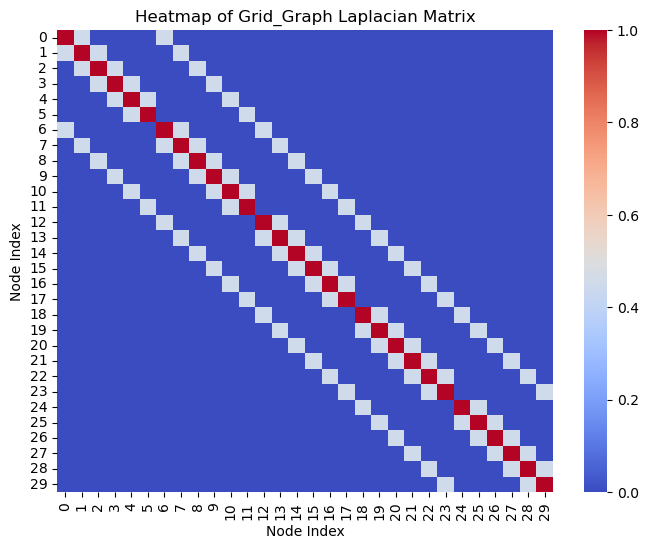

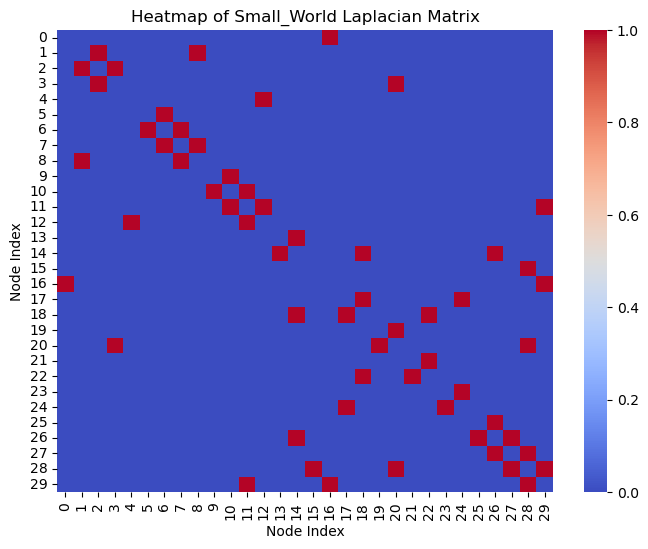

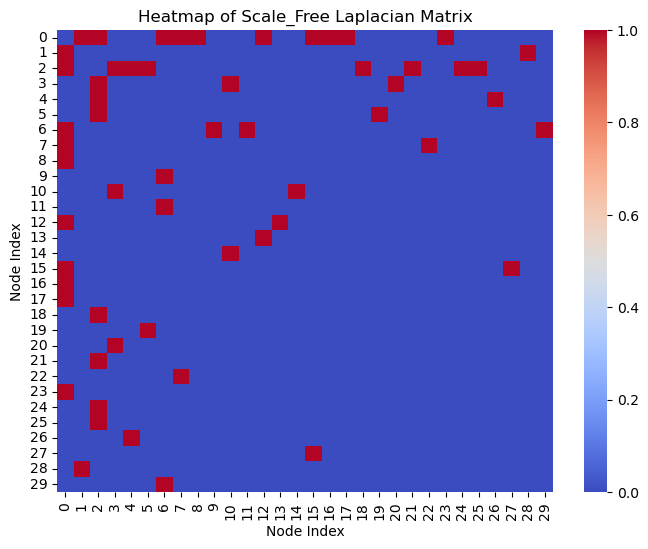

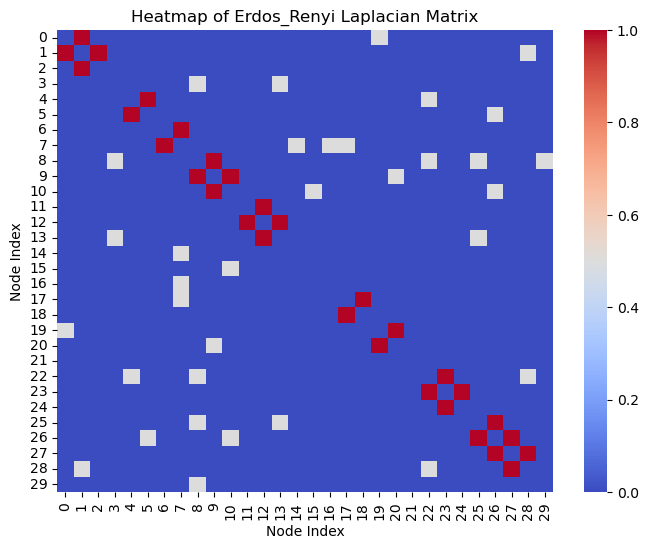

{'Grid_Graph': 'Grid_Graph_Laplacian.csv',
 'Small_World': 'Small_World_Laplacian.csv',
 'Scale_Free': 'Scale_Free_Laplacian.csv',
 'Erdos_Renyi': 'Erdos_Renyi_Laplacian.csv'}

In [14]:
import numpy as np
import pandas as pd

# Function to convert adjacency matrix to Laplacian matrix
def adjacency_to_laplacian(A):
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return L

# Original adjacency matrices for each network
networks = {
    "Grid_Graph": grid_graph(5,6,0.45).copy(),
    "Small_World": smallw(30,1, 0.5).copy(),
    "Scale_Free": BAgraph_undir(30, 2, 1).copy(),
    "Erdos_Renyi": erdosRenyi(30, 0.2, 2).copy()
}
for name, matrix in networks.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, cmap="coolwarm", annot=False)
    plt.title(f"Heatmap of {name} Laplacian Matrix")
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.show()
for name in networks:
    networks[name] = adjacency_to_laplacian(networks[name])
    np.fill_diagonal(networks[name], np.diagonal(networks[name]) + 1e-01)

# Save matrices to CSV files
file_paths = {}
for name, matrix in networks.items():
    file_path = f"{name}_Laplacian.csv"
    np.savetxt(file_path, matrix, delimiter=",")
    file_paths[name] = file_path

file_paths
